# Along-slope velocity

This recipe uses the horizontal surface velocity fields and projects them onto the bathymetry to calculate the along-topography component. The recipe works with MOM5, but the diagnostics and information needed to adapt to MOM6 are given below.

#### Adapting for MOM6

|Variable | MOM5 diagnostic | Equivalent MOM6 diagnostic | 
|:--------|-----|------|
| Zonal velocity (m/s) | `u` | `uo` | 
| Meridional velocity (m/s) | `v` | `vo` | 
|Depth (m) | `ht` | `deptho` | 

In MOM5 velocities are calculated in the (north-east) corner of the cells, where the dimension names are `xu_ocean` and `yu_ocean`. In MOM6, velocities are calculated in the eastern face of the cell for `uo` and northern face of the cell for `vo`. To adapt this recipe, an option would be to interpolate first `uo` and `vo` to be in the (north-east) corner, where the dimensions are (`xq`, `yq`).

There are a few different options for the zonal and meridional lengths of the cells as well, which we can use depending on how we perform the `xgcm` interpolation and differentiation. For more information on grids and `xgcm`, refer to the [xgcm documentation](https://xgcm.readthedocs.io/en/latest/index.html). 

## MOM5

Load modules

In [1]:
from dask.distributed import Client
import numpy as np
import xarray as xr
import dask

import xgcm
import intake

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm

By default retain metadata after operations. This can retain out-of-date metadata, so some caution is required.

In [2]:
xr.set_options(keep_attrs=True);

Start a cluster with multiple cores

In [3]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44453,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46675,Total threads: 1
Dashboard: /proxy/35909/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:38539,


### Load data

Load the ACCESS-NRI Intake Catalog and get the velocity fields and bathymetry information from the selected experiment.

We will only load one random year within that experiment and from that we'll select the velocities that correspond to the Southern Ocean.

In [4]:
catalog = intake.cat.access_nri
experiment = '01deg_jra55v13_ryf9091'

# Define latitude slices and year to open
lat_slice  = slice(-80, -59)
dates_2086 = '2086.*'

First load bathymetry

In [5]:
hu_ds = catalog[experiment].search(variable='hu', frequency='fx').to_dask()

# Select latitude slice 
hu_ds = hu_ds.sel(yu_ocean=lat_slice)
hu_ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 21MB
Dimensions:   (yu_ocean: 484, xu_ocean: 3600)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    geolon_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
Data variables:
    hu        (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
Attributes: (12/20)
    filename:                                 ocean_grid.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['hu']
    intake_esm_attrs:filename:                ocean_grid.nc
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: point,time: point,time: p...
    intake_esm_attrs:variable_units:          m^2,m^2,dimensionless,m,m,m,m,d...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:temporal_label:          point
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.fx.xt_ocean:3600.xu_ocean...

Now we want to load the velocity fields (we will be working with surface velocities only). We load monthly averages with chunks set to automatic, which is a good way to go unless we are sure how we want to chunk things. 

In [6]:
ds = catalog[experiment].search(variable=['u', 'v'], 
                                frequency='1mon',
                                start_date=dates_2086).to_dask(xarray_open_kwargs={ "chunks": "auto",})

# Select the slice we wanted and the surface level
ds = ds.sel(yu_ocean=lat_slice).sel(st_ocean=0, method='nearest')
uv_ds = ds.mean(dim='time')
uv_ds

<xarray.Dataset> Size: 14MB
Dimensions:   (yu_ocean: 484, xu_ocean: 3600)
Coordinates:
    st_ocean  float64 8B 0.5413
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    v         (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 800), meta=np.ndarray>
    u         (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 800), meta=np.ndarray>
Attributes: (12/17)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['v', 'u']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: mean,,,,time: mean,time: ...
    intake_esm_attrs:variable_units:          yr,days,days since 1900-01-01 0...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:temporal_label:          mean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon.grid_xt_ocean:3600.g...

Load grid information (zonal and meridional cell lengths). There's information for the t-cells and the u-cells.

In [7]:
grid_ds = catalog[experiment].search(variable=['dxt', 'dyt', 'dxu', 'dyu'], frequency='fx').to_dask()
grid_ds = grid_ds.sel(yt_ocean=lat_slice, yu_ocean=lat_slice)
grid_ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 56MB
Dimensions:   (yu_ocean: 484, xu_ocean: 3600, yt_ocean: 483, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    geolon_t  (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    geolon_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
Data variables:
    dxu       (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    dyu       (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
Attributes: (12/20)
    filename:                                 ocean_grid.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['dxu', 'dyu', 'dyt', 'dxt']
    intake_esm_attrs:filename:                ocean_grid.nc
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: point,time: point,time: p...
    intake_esm_attrs:variable_units:          m^2,m^2,dimensionless,m,m,m,m,d...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:temporal_label:          point
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.fx.xt_ocean:3600.xu_ocean...

### Along-slope velocity

We calculate the along-slope velocity component by projecting the velocity field to the tangent vector, $u_{\rm along} = \boldsymbol{u \cdot \hat{t}}$, and the cross-slope component by projecting to the normal vector, $v_{\rm cross} = \boldsymbol{u \cdot \hat{n}}$. The schematic below defines the unit normal normal and tangent vectors for a given bathymetric contour, $\boldsymbol{n}$ and $\boldsymbol{t}$ respectively. 

<img src="images/topographic_gradient_sketch.png" alt="schematic" width="850"/>

Accordingly, the code below calculates the along-slope velocity component as

$$ u_{\rm along} = (u,v) \boldsymbol{\cdot} \left(\frac{h_y}{|\boldsymbol{\nabla} h|} , -\frac{h_x}{|\boldsymbol{\nabla} h|}\right) = 
u \frac{h_y}{|\boldsymbol{\nabla} h|} - v \frac{h_x}{|\boldsymbol{\nabla} h|}, $$  

and similarly the cross-slope velocity component as

$$ v_{\rm cross} = (u,v) \boldsymbol{\cdot} \left(\frac{h_x}{|\boldsymbol{\nabla} h|} , \frac{h_y}{|\boldsymbol{\nabla} h|}\right)  = 
u \frac{h_x}{|\boldsymbol{\nabla} h|} + v \frac{h_y}{|\boldsymbol{\nabla} h|}.$$ 


We need the derivatives of the bathymetry which we compute using the `xgcm`.

In [8]:
# We need to merge the two datasets. They're on the same coordinates, so this should be straightforward.
ds = xr.merge([hu_ds, grid_ds])

# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
ds

<xarray.Dataset> Size: 63MB
Dimensions:   (yu_ocean: 484, xu_ocean: 3600, yt_ocean: 483, xt_ocean: 3600)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    geolon_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
    geolon_t  (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
Data variables:
    hu        (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    dxu       (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    dyu       (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
Attributes: (12/20)
    filename:                                 ocean_grid.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['hu']
    intake_esm_attrs:filename:                ocean_grid.nc
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: point,time: point,time: p...
    intake_esm_attrs:variable_units:          m^2,m^2,dimensionless,m,m,m,m,d...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:temporal_label:          point
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.fx.xt_ocean:3600.xu_ocean...

For `xgcm` to work correctly, there center and corner (t-cells and u-cells) dimensions must have the same size and be staggered in the correct way (u-cells to the north-east of the t-cells). As we can see in the above `ds` the meridional dimensions are not of the same size. We need to remove the first point in `yu_ocean`.

In [9]:
ds = ds.isel(yu_ocean=slice(1, None))

# Create grid object
grid = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')

# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

Calculate along-slope velocity component

In [10]:
# Get the u and v data arrays out of our dataset
uv_ds = uv_ds.isel(yu_ocean=slice(1, None))
u, v = uv_ds['u'], uv_ds['v']

# Mask zeros to avoid error warnings when dividing
topographic_slope_magnitude = topographic_slope_magnitude.where(topographic_slope_magnitude != 0)

# Along-slope velocity
alongslope_velocity = u * dhu_dy / topographic_slope_magnitude - v * dhu_dx / topographic_slope_magnitude
alongslope_velocity 

<xarray.DataArray (yu_ocean: 483, xu_ocean: 3600)> Size: 7MB
dask.array<sub, shape=(483, 3600), dtype=float32, chunksize=(483, 800), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.95 -79.9 -79.86 ... -59.06 -59.01
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

### Plotting

Create a land mask for plotting, set land cells to 1 and rest to zeros

In [11]:
land = xr.where(np.isnan(hu_ds['hu'].rename('land')), 1, 0)

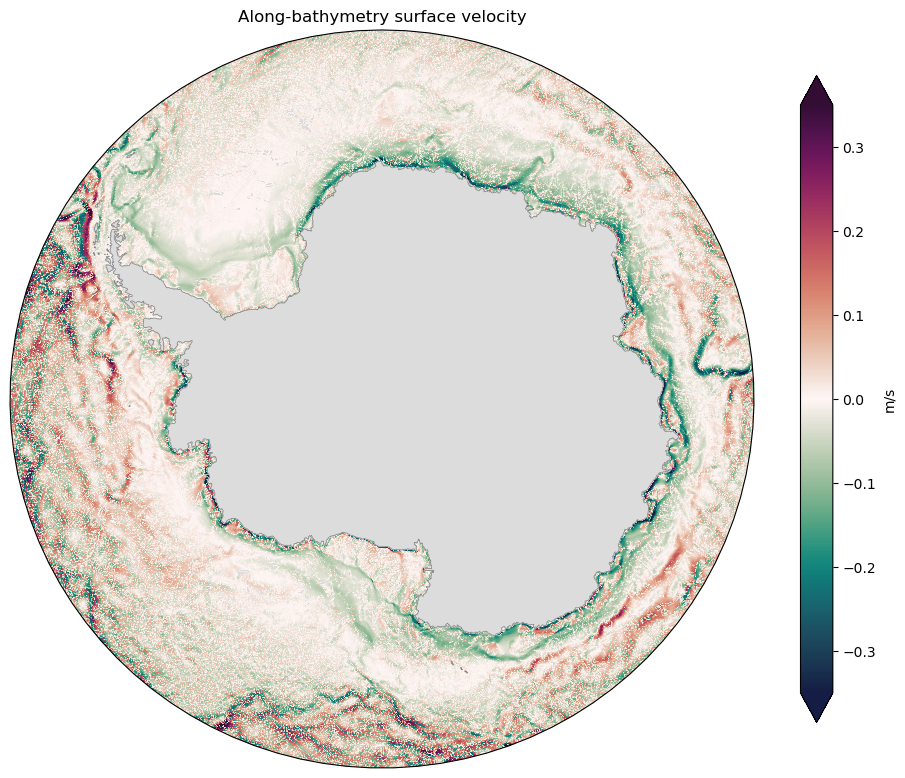

In [12]:
projection = ccrs.SouthPolarStereo()

plt.figure(figsize=(12, 12))
ax = plt.axes(projection=projection, facecolor='gainsboro')

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Plot land mask
land.where(land==1).plot.contourf(ax=ax, 
                                  colors=['gainsboro'], 
                                  add_colorbar=False,
                                  transform=ccrs.PlateCarree())
land.plot.contour(ax=ax, 
                  levels=[0.99], 
                  colors=['grey'], 
                  linewidths=[0.5],
                  transform=ccrs.PlateCarree())

# Plot along slope surface velocities
alongslope_velocity.plot(ax=ax, 
                         cmap=cm.cm.curl,
                         vmin=-0.35, vmax=0.35, extend='both',
                         cbar_kwargs={'shrink': 0.7,
                                      'label': 'm/s'},
                         transform=ccrs.PlateCarree())

ax.set_title('Along-bathymetry surface velocity');

In [13]:
client.close()